# LLAMA3 Fine-tuning for machine translation


In [10]:
%pip install torch tensorboard evaluate scikit-learn transformers peft nltk seaborn trl

Note: you may need to restart the kernel to use updated packages.


In [1]:
from huggingface_hub import login
import os
import time
import pandas as pd
import torch.cuda
import torch
from torch.utils.tensorboard import SummaryWriter
import os
import random
import functools
import csv
import pandas as pd
import numpy as np
import torch.nn.functional as F
import evaluate
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainer, Seq2SeqTrainingArguments
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, classification_report, balanced_accuracy_score, accuracy_score
from transformers import AutoModelForCausalLM, AutoTokenizer
from scipy.stats import pearsonr
from datasets import Dataset, DatasetDict
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model

from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)

/home/lujun_li/anaconda3/envs/mt_luxembourgish_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Data and set env

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from datasets import load_from_disk, load_dataset


current = time.time()
writer = SummaryWriter(log_dir=f"logs/fit_{current}/")

learning_rate = 1e-4
per_device_train_batch_size = 1
per_device_eval_batch_size = 1
num_train_epochs = 5
weight_decay = 0.01
MAX_LEN = 512

# Load validation and training datasets
model_name = "/home/lujun_li/projects/base_models/Llama-3.2-1B-Instruct"

val_dataset = load_from_disk("/home/lujun_li/projects/mt_luxembourgish/data/fake_targets/flores_devtest_arrow")
train_dataset = load_from_disk("/home/lujun_li/projects/mt_luxembourgish/data/fake_targets/NC_LUX.arrow").select_columns(["subsentence", "translated_text"]).rename_columns({
    "subsentence": "sentence_ltz_Latn",  # Renaming 'subsentence' to 'sentence_eng_Latn'
    "translated_text": "sentence_eng_Latn"  # Renaming 'translated_text' to 'sentence_ltz_Latn'
}).select([i for i in range(1000)])

# Convert datasets to dictionaries
dataset = DatasetDict({ 'train': train_dataset, 'val': val_dataset})
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence_ltz_Latn', 'sentence_eng_Latn'],
        num_rows: 1000
    })
    val: Dataset({
        features: ['sentence_eng_Latn', 'sentence_ltz_Latn'],
        num_rows: 1012
    })
})

## Load Model


In [3]:

# Quantization
quantization_config = BitsAndBytesConfig(
    load_in_4bit = True, # enable 4-bit quantization
    bnb_4bit_quant_type = 'nf4', # information theoretically optimal dtype for normally distributed weights
    bnb_4bit_use_double_quant = True, # quantize quantized weights //insert xzibit meme
    bnb_4bit_compute_dtype = torch.bfloat16 # optimized fp format for ML
)

# Lora
lora_config = LoraConfig(
    r = 16, # the dimension of the low-rank matrices
    lora_alpha = 8, # scaling factor for LoRA activations vs pre-trained weight activations
    target_modules = ['q_proj', 'k_proj', 'v_proj', 'o_proj'],
    lora_dropout = 0.05, # dropout probability of the LoRA layers
    bias = 'none', # wether to train bias weights, set to 'none' for attention layers
    task_type="CAUSAL_LM",
)

In [4]:
tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.pad_token = tokenizer.eos_token


In [5]:
# Create LLAMA tokenized dataset which will save time
def llama_preprocessing_function(examples):
    # Tokenize both English and Luxembourgish sentences
    tokenized_input = tokenizer(examples['sentence_ltz_Latn'], truncation=True, max_length=MAX_LEN, return_tensors="pt", padding='max_length')  # max length set to 512 for accelerating training
    tokenized_target = tokenizer(examples['sentence_eng_Latn'], truncation=True, max_length=MAX_LEN, return_tensors="pt", padding='max_length')
    
    # Return the tokenized sentences
    return {
        'input_ids': tokenized_input['input_ids'],
        'attention_mask': tokenized_input['attention_mask'],
        'labels': tokenized_target['input_ids']
    }

tokenized_datasets = dataset.map(llama_preprocessing_function, batched=True)
tokenized_datasets.set_format("torch")

# Data collator and trainer


In [6]:
from accelerate import Accelerator
from transformers import DataCollatorWithPadding, TrainingArguments
from trl import SFTTrainer

def train_ddp_accelerate():
    
    model = AutoModelForCausalLM.from_pretrained(model_name)
    model = prepare_model_for_kbit_training(model)
    # model = get_peft_model(model, lora_config)
    model.config.pad_token_id = tokenizer.pad_token_id
    model.config.use_cache = False
    model.config.pretraining_tp = 1

    class CustomSFTTrainer(SFTTrainer):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # Initialize TensorBoard writer
            log_dir = kwargs.get('args').output_dir  # Use the training output directory
            self.writer = writer

        def log(self, logs):
            """
            Override the default log method to add custom TensorBoard logging.
            """
            super().log(logs)  # Call the parent class's log method
            if self.state.global_step is not None:
                for key, value in logs.items():
                    if isinstance(value, (int, float)):
                        self.writer.add_scalar(key, value, self.state.global_step)

    
    # Define the data collator
    collate_fn = DataCollatorWithPadding(tokenizer=tokenizer)

    # Define training arguments
    training_args = TrainingArguments(
        output_dir=f"logs/fit_{current}",
        learning_rate=learning_rate,
        per_device_train_batch_size=per_device_train_batch_size,
        per_device_eval_batch_size=per_device_eval_batch_size,
        num_train_epochs=num_train_epochs,
        weight_decay=weight_decay,
        evaluation_strategy='epoch',
        save_strategy='epoch',
        load_best_model_at_end=True,
        report_to="tensorboard",
        ddp_find_unused_parameters=False,
        lr_scheduler_type="linear",
        warmup_steps=10
    )

    # Define the trainer
    trainer = CustomSFTTrainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets['train'],
        eval_dataset=tokenized_datasets['val'],
        tokenizer=tokenizer,
        data_collator=collate_fn,
        peft_config=lora_config,
    )

    # Start training
    train_result = trainer.train()

    # Close the writer
    writer.close()



# Run trainer

In [7]:
from accelerate import notebook_launcher

# Call the function using notebook_launcher
notebook_launcher(
    train_ddp_accelerate, 
    args=(), 
    num_processes=1
)


Launching training on one GPU.


/home/lujun_li/anaconda3/envs/mt_luxembourgish_env/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/home/lujun_li/anaconda3/envs/mt_luxembourgish_env/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/home/lujun_li/anaconda3/envs/mt_luxembourgish_env/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:309: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


KeyboardInterrupt: 

# Check the results


In [ ]:
def make_predictions(model, df):
    # Convert the 'text' column of the dataframe to a list of sentences
    sentences = df.text.tolist()
    batch_size = 1  # Set the batch size for processing sentences
    all_outputs = []  # Initialize a list to store model outputs

    # Iterate over sentences in batches
    for i in range(0, len(sentences), batch_size):
        batch_sentences = sentences[i:i + batch_size]  # Get the current batch of sentences
        # Tokenize the batch of sentences
        inputs = tokenizer(batch_sentences, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN)
        # Move inputs to the appropriate device (GPU if available, otherwise CPU)
        inputs = {k: v.to('cuda' if torch.cuda.is_available() else 'cpu') for k, v in inputs.items()}
        
        # Disable gradient calculation for inference
        with torch.no_grad():
            # Get model outputs for the current batch
            outputs = model(**inputs)
            # Append the logits (raw model outputs) to the list
            all_outputs.append(outputs['logits'])

    # Concatenate all batch outputs into a single tensor
    final_outputs = torch.cat(all_outputs, dim=0)
    # Add a new column 'predictions' to the dataframe with the predicted class indices
    df['predictions'] = final_outputs.argmax(axis=1).cpu().numpy()
    # Map the predicted class indices to their corresponding category names
    df['predictions'] = df['predictions'].apply(lambda l: category_map[l])


### Analyze performance

In [ ]:
def get_performance_metrics(df_test):
    # Round the 'label_ascat' column to get the true labels
    y_test = df_test.label_ascat.round()
    # Round the 'predictions' column to get the predicted labels
    y_pred = df_test.predictions.round()
    # Print the true and predicted labels for comparison
    print(f"comparing test {y_test} and pred {y_pred}")

    # Print the confusion matrix to show the performance of the classification
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    # Print the classification report for detailed performance metrics
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Print the balanced accuracy score
    print("Balanced Accuracy Score:", balanced_accuracy_score(y_test, y_pred))
    # Print the overall accuracy score
    print("Accuracy Score:", accuracy_score(y_test, y_pred))

    # Return the classification report as a dictionary
    return classification_report(y_test, y_pred, output_dict=True)

def get_classification_metrics(report):
    # Extract precision, recall, and f1-score for 'Non' and 'Oui' classes from the report
    metrics = {
        'Non': {
            'precision': report['Non']['precision'],
            'recall': report['Non']['recall'],
            'f1-score': report['Non']['f1-score']
        },
        'Oui': {
            'precision': report['Oui']['precision'],
            'recall': report['Oui']['recall'],
            'f1-score': report['Oui']['f1-score']
        }
    }
    # Return the extracted metrics
    return metrics


## Read all model checkpoints in the folder to test

In [ ]:
import os

def list_files_in_folder(folder_path):
    # List all files in the given folder
    files = os.listdir(folder_path)
    list_files = []
    for file in files:
        if "checkpoint-" in file:
            list_files.append(file)
    return list_files

folder_path = 'fit_1727983778.4684527'
models = list_files_in_folder(folder_path)
metrics_list = []
epochs_list = []

for model_path in models:
    model = AutoModelForSequenceClassification.from_pretrained(
        f"{folder_path}/{model_path}",
        quantization_config=quantization_config,
        num_labels=len(category_map),
    )
    make_predictions(model,df_val)
    report = get_performance_metrics(df_val)
    metrics = get_classification_metrics(report)
    metrics_list.append(metrics)
    epochs_list.append(model_path.split("-")[-1])

`low_cpu_mem_usage` was None, now set to True since model is quantized.
Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]
Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at Llama-3.2-3B-Instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


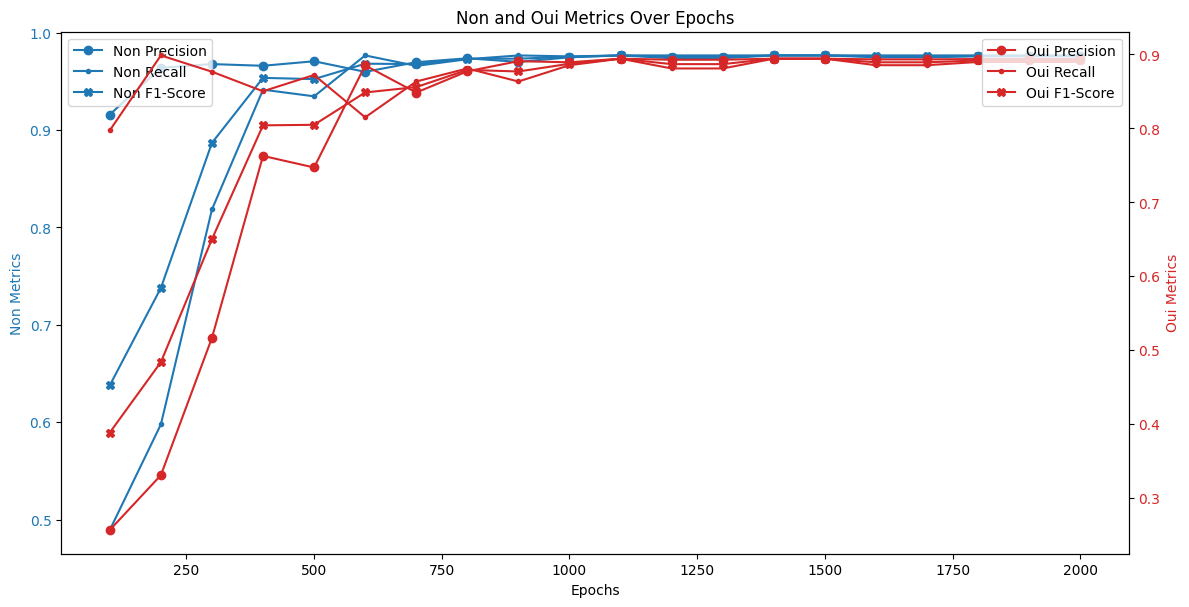

: 

In [ ]:
import matplotlib.pyplot as plt

non_precision = []
non_recall = []
non_f1_score = []
oui_precision = []
oui_recall = []
oui_f1_score = []

# Iterate through the metrics_list and append the values to the respective lists
for metrics in metrics_list:
    non_precision.append(metrics['Non']['precision'])
    non_recall.append(metrics['Non']['recall'])
    non_f1_score.append(metrics['Non']['f1-score'])
    oui_precision.append(metrics['Oui']['precision'])
    oui_recall.append(metrics['Oui']['recall'])
    oui_f1_score.append(metrics['Oui']['f1-score'])


epochs = [int(epoch) for epoch in epochs_list]

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting Non metrics on the first y-axis
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Non Metrics', color='tab:blue')
ax1.plot(epochs, non_precision, label='Non Precision', marker='o', color='tab:blue')
ax1.plot(epochs, non_recall, label='Non Recall', marker='.', color='tab:blue')
ax1.plot(epochs, non_f1_score, label='Non F1-Score', marker='X', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper left')

# Creating a second y-axis for Oui metrics
ax2 = ax1.twinx()
ax2.set_ylabel('Oui Metrics', color='tab:red')
ax2.plot(epochs, oui_precision, label='Oui Precision', marker='o', color='tab:red')
ax2.plot(epochs, oui_recall, label='Oui Recall', marker='.', color='tab:red')
ax2.plot(epochs, oui_f1_score, label='Oui F1-Score', marker='X', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.legend(loc='upper right')

# Show the plot
fig.tight_layout()
plt.title('Non and Oui Metrics Over Epochs')
plt.show()

## Or just load one model checkpoint to test

In [ ]:
folder_path = 'logs/fit_1727983778.4684527'
model_path = "checkpoint-2000/"
model = AutoModelForSequenceClassification.from_pretrained(
    f"{folder_path}/{model_path}",
    quantization_config=quantization_config,
    num_labels=len(category_map),
)
make_predictions(model,df_val)
report = get_performance_metrics(df_val)
metrics = get_classification_metrics(report)